# Graph analysis of a *.pcap file

This notebook intends to build a graph object out of a *.pcap file and compute some basic metrics with the NetworkX library.

In [28]:
# imports

import numpy as np
import pandas as pg
import matplotlib.pyplot as plt
import logging
import collections
import seaborn as sns

import pyshark
import networkx as nx

# PATH change to access library cyberlib
import sys
sys.path.append('/home/benjamin/Folders_Python/Cyber/libs')
import cyberlib as cbl

In [2]:
# logging set-up for debugging purposes

LOG_FILENAME = '/home/benjamin/Folders_Python/Cyber/logs/graph_logfile.log'
LOG_FORMAT = '%(asctime)% -- %(name)s -- %(levelname)s -- %(message)s'
# LOG_LEVEL = logging.INFO

# specific logger for the module
logger = logging.getLogger(__name__)   # creates specific logger for the module
logger.setLevel(logging.DEBUG)    # entry level of messages from all handlers
LOG_FORMAT = '%(asctime)s -- %(name)s -- %(levelname)s -- %(message)s'
formatter = logging.Formatter(LOG_FORMAT)

# file handler to log everything
file_handler = logging.FileHandler(LOG_FILENAME, mode='w')
file_handler.setLevel(logging.INFO)  # all messages (DEBUG and up) get logged in the file
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# stream handler to show messages to the console
console = logging.StreamHandler()
console.setLevel(logging.WARNING)  # Warning messages and up get displayed to the console
console.setFormatter(formatter)
logger.addHandler(console)

# start your engine
logger.info("-------- new run --------")

Get the *.pcap file to play with

In [3]:
PCAPFILE = '/home/benjamin/Folders_Python/Cyber/data/input_pcaps/smallFlows.pcap'

In [4]:
capture = pyshark.FileCapture(
    input_file=PCAPFILE,
    use_ek=False
)

logger.info(f'-- created a capture object in PyShark with pcap file = {PCAPFILE} --')

Graph creation : we build an undirected graph
- the nodes are the different IP adresses
- the edges exist when there is at least one packet between two nodes, and the edges features are the number of packets between nodes

In [5]:
# get list of packets that are part on an IP conversation
list_ip_packets = [ cbl.PyPacket(raw_pkt).data.get('IP') for raw_pkt in capture if (cbl.PyPacket(raw_pkt).data.get('IP') is not None) ]

# get the list of IPs, put it in the right format for the G.add_nodes_from() in NetworkX
raw_list_src_ips = [ ip.get('src') for ip in list_ip_packets ]
raw_list_dst_ips = [ ip.get('dst') for ip in list_ip_packets ]
raw_list_ips = [ *raw_list_src_ips, *raw_list_dst_ips ]
list_ips = list(collections.Counter(raw_list_ips).keys())
list_ips.sort()

print(f'there is {len(list_ips)} different IP adresses, and {len(list_ip_packets)} packets in IP conversations')

there is 222 different IP adresses, and 14243 packets in IP conversations


In [6]:
# computes edges, put it in the right format for the G.add_edges_from() in NetworkX
dict_edges = {}

for ip_packet in list_ip_packets:
    src = ip_packet.get('src')
    dst = ip_packet.get('dst')
    if src <= dst:
        key = (src, dst)
    else:
        key = (dst, src)
    if key in dict_edges:
        dict_edges[key] += 1
    else:
        dict_edges[key] = 1
        
list_edges = [ (k[0], k[1], {'nb_pkts' : v} ) for k,v in dict_edges.items() ]

print(f'there is {len(list_edges)} links between IP adresses')

there is 224 links between IP adresses


In [7]:
# build and display the graph

G = nx.Graph()

G.add_nodes_from(list_ips)
G.add_edges_from(list_edges)

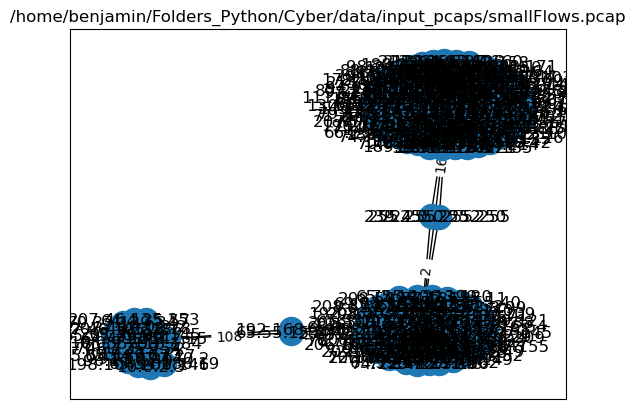

In [10]:
# nx.draw_networkx(G, with_labels=True)
# nx.draw_networkx_edge_labels(G, edge_labels=dict_edges)

fig, ax = plt.subplots()

l = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=l, ax=ax)
nx.draw_networkx_labels(G, pos=l, ax=ax)
nx.draw_networkx_edges(G, pos=l)
nx.draw_networkx_edge_labels(G, pos=l, edge_labels=dict_edges, ax=ax)
ax.set_title(f'{PCAPFILE}')
plt.show()

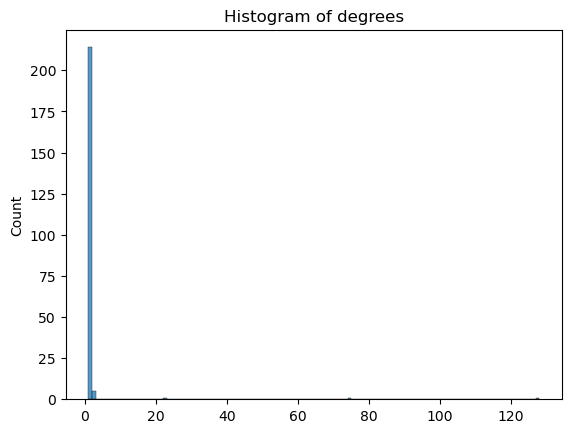

In [34]:
# computes some metrics

# degree : number of edges connected to a node
degs = nx.degree(G)

x = [ t[1] for t in list(degs)]
fig, ax = plt.subplots()
sns.histplot(x, ax=ax, binwidth=1)
ax.set_title('Histogram of degrees')
plt.show()

In [36]:
# density : d = 2 * nb_edges / ( nb_nodes * (nb_nodes-1) )
# 0 for a graph without edge
# 1 for a complete graph

print(f'Density is {nx.density(G):.3f}')

Density is 0.009
